# Seminar 4 - Dense Prediction

## Warm-up

### Case 1
You want to implement operation `Conv2dWithStride(in_channels, out_channels, kernel_size, padding, stride)`. 

You have a library that has operation `Conv2dWithoutStride(in_channels, out_channels, kernel_size, padding)` and slicing operation. 

How to implement `Conv2dWithStride` ?

In [1]:
import torch.nn as nn
import torch
import numpy as np
Conv2dWithoutStride = nn.Conv2d


class Conv2dWithStride(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, stride):
        super().__init__()
        # YOUR CODE
        self.nn = Conv2dWithoutStride(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding
        )
        self.stride = stride
        
    def forward(self, x):
        # YOUR CODE
        out = self.nn(x)
        return out[..., ::self.stride, ::self.stride] # stride only two last dimensions

In [2]:
def test_case1():
    with torch.no_grad():
        conv_gt = nn.Conv2d(in_channels=10, out_channels=1, kernel_size=5, padding=2, stride=2)
        conv_custom = Conv2dWithStride(in_channels=10, out_channels=1, kernel_size=5, padding=2, stride=2)
        conv_custom.nn.weight = conv_gt.weight
        conv_custom.nn.bias = conv_gt.bias

        for _ in range(10):
            data = np.random.random((1, 10, 16, 16))
            data = torch.FloatTensor(data)
            
            res1 = conv_gt(data).numpy()
            res2 = conv_custom(data).numpy()
            assert np.allclose(res1, res2, atol=1e-5), np.linalg.norm(res1 - res2)
            
test_case1()

### Case 2

You have a library that has an operation `Conv2dWithoutStride(in_channels, out_channels, kernel_size, padding, dilation)`. This library don't provide slicing operation over torch tensors, but you still have slicing operation in numpy. You want to create Sequential which will work like Conv2d(..., stride=2) + Conv2d(..., stride=1) using `Conv2dWithoutStride`. 

How to do it?

In [3]:
class Case2GT(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=2, kernel_size=5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=3, padding=1)
        
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        return y
    
class Case2Custom(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE
        self.conv1 = Conv2dWithoutStride(in_channels=10, out_channels=2, kernel_size=5, padding=2)
        self.conv2 = Conv2dWithoutStride(in_channels=2, out_channels=3, kernel_size=3, padding=1, dilation=2)
        self.stride = 2
        
    def forward(self, x):
        # YOUR CODE
#         out1 = self.conv1(x).cpu().detach().numpy()[..., ::self.stride, ::self.stride]
        print(x.shape)
        out1 = self.conv1(x)
        print(out1.shape)
        out2 = self.conv2(out1)
        print(out2.shape)
        return out2


In [4]:
# def test_case2():
#     with torch.no_grad():
#         gt = Case2GT()
#         custom = Case2Custom()
        
#         custom.conv1.weight = gt.conv1.weight
#         custom.conv1.bias = gt.conv1.bias
#         custom.conv2.weight = gt.conv2.weight
#         custom.conv2.bias = gt.conv2.bias

#         for _ in range(10):
#             data = np.random.random((1, 10, 16, 16))
#             data = torch.FloatTensor(data)
            
#             res1 = gt(data).numpy()
#             res2 = custom(data).numpy()
#             assert np.allclose(res1, res2, atol=1e-5), np.linalg.norm(res1 - res2)
            
# test_case2()

### Case 3

Same as in Case 2, but now the initial setup is Conv2d(..., stride=2) + Conv2d(..., stride=1) + Conv2d(..., stride=1) 

In [5]:
class Case3GT(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=10, out_channels=2, kernel_size=5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1)
        
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        return y
    
class Case3Custom(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE
        self.conv1 = Conv2dWithoutStride(...)
        self.conv2 = Conv2dWithoutStride(...)
        self.conv3 = Conv2dWithoutStride(...)
        self.stride = 2
        
    def forward(self, x):
        # YOUR CODE
        raise NotImplementedError

In [6]:
# def test_case3():
#     with torch.no_grad():
#         gt = Case3GT()
#         custom = Case3Custom()
        
#         custom.conv1.weight = gt.conv1.weight
#         custom.conv1.bias = gt.conv1.bias
#         custom.conv2.weight = gt.conv2.weight
#         custom.conv2.bias = gt.conv2.bias
#         custom.conv3.weight = gt.conv3.weight
#         custom.conv3.bias = gt.conv3.bias

#         for _ in range(10):
#             data = np.random.random((1, 10, 16, 16))
#             data = torch.FloatTensor(data)
            
#             res1 = gt(data).numpy()
#             res2 = custom(data).numpy()
#             assert np.allclose(res1, res2, atol=1e-5), np.linalg.norm(res1 - res2)
            
# test_case3()

## Seminar

Your task is to convert image classification network into fully-convolutional network that predicts value for every patch on image.

What we have:
* network trained to predict whether the central pixel of patch of size 114x114 belong to class 'road'
* image that we want to segment

Let's firstly look on the data

In [7]:
import scipy as sp
import scipy.misc
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

In [8]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [9]:
# if running in colab or datasphere, uncomment this:
#os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/um_000081-pred.png -O um_000081-pred.png")
#os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/layer_wrappers.py -O layer_wrappers.py")
#os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/um_000081.png -O um_000081.png")
#os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring21/seminar05-dense_prediction/um_road_000081.png -O um_road_000081.png")

In [10]:
%pip install scikit-image

You should consider upgrading via the '/home/german.petrov/Desktop/dvg_solutions/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
os.system("wget https://www.dropbox.com/s/429eqmyi3dbhzrg/model2.npz?dl=0 -O model2.npz")
# alternative link: https://yadi.sk/d/I1kHDWZTnH4DAw (for manual downloading only)

--2022-09-09 01:49:23--  https://www.dropbox.com/s/429eqmyi3dbhzrg/model2.npz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6026:18::a27d:4612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/429eqmyi3dbhzrg/model2.npz [following]
--2022-09-09 01:49:24--  https://www.dropbox.com/s/raw/429eqmyi3dbhzrg/model2.npz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb90ed2a883c0c01cfda1b6d882.dl.dropboxusercontent.com/cd/0/inline/Bsn-y7CzRZKE1l-qO3C_SOh7KkqVfjW587j8kSV4xsyyFfLiTAz5POqfDqSSEsUGo7a_tdI-gA9lgiCruHpNo-mUVDxs9c72cMJ1UHKvBdJJCjiZ_7sOsyXNT5YVRkGv3mPUdccg3i6ZE7sCWv1FWZaIoJl2LTk7ouq9T4_HveaWpg/file# [following]
--2022-09-09 01:49:24--  https://ucb90ed2a883c0c01cfda1b6d882.dl.dropboxusercontent.com/cd/0/inline/Bsn-y7CzRZKE1l-qO3C_SOh7KkqVfjW587j8kSV4xsyyFfLiTAz5POqfDqSSEsUGo7a_tdI-gA9lgi

  4250K .......... .......... .......... .......... .......... 19% 1.93M 2s
  4300K .......... .......... .......... .......... .......... 19% 59.4M 2s
  4350K .......... .......... .......... .......... .......... 20% 51.1M 2s
  4400K .......... .......... .......... .......... .......... 20% 34.9M 2s
  4450K .......... .......... .......... .......... .......... 20% 68.9M 2s
  4500K .......... .......... .......... .......... .......... 20% 76.9M 2s
  4550K .......... .......... .......... .......... .......... 21% 48.1M 2s
  4600K .......... .......... .......... .......... .......... 21% 38.0M 2s
  4650K .......... .......... .......... .......... .......... 21% 47.2M 2s
  4700K .......... .......... .......... .......... .......... 21% 46.2M 2s
  4750K .......... .......... .......... .......... .......... 21% 46.0M 2s
  4800K .......... .......... .......... .......... .......... 22% 58.0M 2s
  4850K .......... .......... .......... .......... .......... 22% 65.6M 1s
  4900K ....

 10350K .......... .......... .......... .......... .......... 47%  710K 1s
 10400K .......... .......... .......... .......... .......... 47%  141M 1s
 10450K .......... .......... .......... .......... .......... 48% 50.2M 1s
 10500K .......... .......... .......... .......... .......... 48% 50.4M 1s
 10550K .......... .......... .......... .......... .......... 48%  134M 1s
 10600K .......... .......... .......... .......... .......... 48%  196M 1s
 10650K .......... .......... .......... .......... .......... 48% 74.0M 1s
 10700K .......... .......... .......... .......... .......... 49% 23.7M 1s
 10750K .......... .......... .......... .......... .......... 49%  154M 1s
 10800K .......... .......... .......... .......... .......... 49% 29.9M 1s
 10850K .......... .......... .......... .......... .......... 49%  197M 1s
 10900K .......... .......... .......... .......... .......... 50%  184M 1s
 10950K .......... .......... .......... .......... .......... 50% 30.4M 1s
 11000K ....

 20700K .......... .......... .......... .......... .......... 94%  552K 0s
 20750K .......... .......... .......... .......... .......... 95%  161M 0s
 20800K .......... .......... .......... .......... .......... 95%  211M 0s
 20850K .......... .......... .......... .......... .......... 95%  197M 0s
 20900K .......... .......... .......... .......... .......... 95%  194M 0s
 20950K .......... .......... .......... .......... .......... 96%  182M 0s
 21000K .......... .......... .......... .......... .......... 96%  196M 0s
 21050K .......... .......... .......... .......... .......... 96%  192M 0s
 21100K .......... .......... .......... .......... .......... 96%  190M 0s
 21150K .......... .......... .......... .......... .......... 96%  158M 0s
 21200K .......... .......... .......... .......... .......... 97%  200M 0s
 21250K .......... .......... .......... .......... .......... 97%  206M 0s
 21300K .......... .......... .......... .......... .......... 97%  195M 0s
 21350K ....

0

In [12]:
def read_image(img_name, gt_name=None):
    IMG_HEIGHT = 256
    im = skimage.io.imread(img_name)
    im = skimage.transform.rescale(im, IMG_HEIGHT * 1. / im.shape[0], multichannel=True)
    im = skimage.img_as_ubyte(im)
    if gt_name is not None:
        gt = (skimage.io.imread(gt_name)[:,:,-1]==255).astype(np.uint8)*255
        gt = skimage.transform.rescale(gt, IMG_HEIGHT * 1. / gt.shape[0], order=0, preserve_range=True)
        gt = (gt > 0).astype(np.uint8)
        return im, gt
    return im

def make_blending(img, labels, alpha=0.5):
    colors = np.array([[0,0,0], [0,255,0]], np.uint8)
    return (img*alpha + colors[labels.astype(np.int32)]*(1. - alpha)).astype(np.uint8)

/tmp/ipykernel_15003/2749351133.py:4: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im = skimage.transform.rescale(im, IMG_HEIGHT * 1. / im.shape[0], multichannel=True)


([], [])

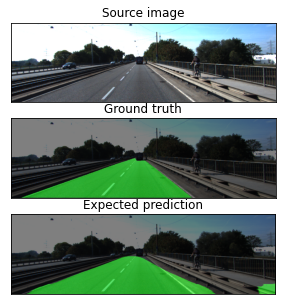

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(3,1,1)
im, gt = read_image('./um_000081.png', './um_road_000081.png')
plt.imshow(im)
plt.title('Source image')
plt.xticks([]); plt.yticks([])
plt.subplot(3,1,2)
plt.imshow(make_blending(im, gt))
plt.title('Ground truth')
plt.xticks([]); plt.yticks([])
plt.subplot(3,1,3)
pred = skimage.io.imread('./um_000081-pred.png')
plt.imshow(pred)
plt.title('Expected prediction')
plt.xticks([]); plt.yticks([])


Semantic image segmentation problem could be considered as a problem of prediction label for the central pixel in image patch of predefined size. It allows us to use a lot of NN archtectures specifically designed for image classification (thanks to ImageNet Competition)

In [14]:
def get_valid_patches(img_shape, patch_size, central_points):
    start = central_points - patch_size/2
    end = start + patch_size
    mask = np.logical_and(start >= 0, end < np.array(img_shape))
    mask = np.all(mask, axis=-1)
    return mask

def extract_patches(img, mask, n_pos=64, n_neg=64, patch_size=100):
    res = []
    labels = []
    pos = np.argwhere(mask > 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, pos)
    pos = pos[accepted_patches_mask]
    np.random.shuffle(pos)
    for i in range(n_pos):
        start = pos[i] - patch_size//2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(1)
        
    neg = np.argwhere(mask == 0)
    accepted_patches_mask = get_valid_patches(np.array(img.shape[:2]), patch_size, neg)
    neg = neg[accepted_patches_mask]
    np.random.shuffle(neg)
    for i in range(n_neg):
        start = neg[i] - patch_size//2
        end = start + patch_size
        res.append(img[start[0]:end[0], start[1]:end[1]])
        labels.append(0)
    return np.array(res), np.array(labels)

In [15]:
patches, labels = extract_patches(im, gt, 32,32, patch_size=114)

Road-centered patches

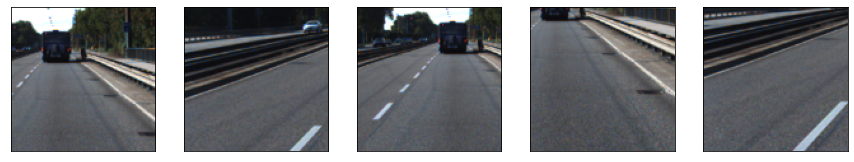

In [16]:
plt.figure(figsize=(15,3))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(patches[i])
    plt.xticks([]); plt.yticks([])

Non-road-centered patches

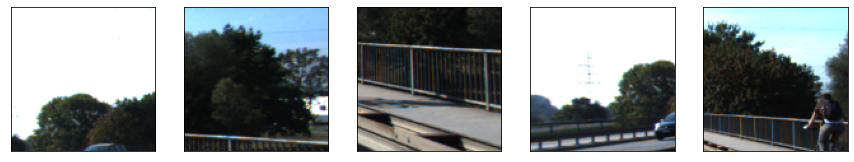

In [17]:
plt.figure(figsize=(15,3))
for i in range(1,6):
    plt.subplot(1,5,i)
    plt.imshow(patches[-i])
    plt.xticks([]); plt.yticks([])

Here is our pretrained network

In [18]:
with np.load('./model2.npz', encoding='latin1', allow_pickle=True) as f:
    weights = f['state'].tolist()  # getting np.array content; it's dict in fact, not list

In [19]:
from layer_wrappers import *
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class ClassifierModel(nn.Module):
    def __init__(
        self,
        weights
    ):
        super().__init__()
        
        # block 1
        self.block1 = nn.Sequential(
            Conv2d(
                in_channels=3, out_channels=32, kernel_size=3, bias=False, 
                padding=0, weight_init=weights['conv1_1_w']
            ),
            BatchNorm2d(
                num_features=32, weight_init=weights['bn1_1_w'], 
                bias_init=weights['bn1_1_b'], mean_init=weights['bn1_1_mean'],
                var_init=weights['bn1_1_var']
            ),
            nn.ReLU(inplace=True),
            Conv2d(
                in_channels=32, out_channels=32, kernel_size=3, bias=False, padding=0, 
                weight_init=weights['conv1_2_w']
            ),
            BatchNorm2d(
                num_features=32, weight_init=weights['bn1_2_w'], 
                bias_init=weights['bn1_2_b'], mean_init=weights['bn1_2_mean'],
                var_init=weights['bn1_2_var']
            ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        )
        
        # block 2
        self.block2 = nn.Sequential(
            Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv2_1_w']
            ),
            BatchNorm2d(
                num_features=64, weight_init=weights['bn2_1_w'], 
                bias_init=weights['bn2_1_b'], mean_init=weights['bn2_1_mean'],
                var_init=weights['bn2_1_var']
            ),
            nn.ReLU(inplace=True),
            Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv2_2_w']
            ),
            BatchNorm2d(
                num_features=64, weight_init=weights['bn2_2_w'], 
                bias_init=weights['bn2_2_b'], mean_init=weights['bn2_2_mean'],
                var_init=weights['bn2_2_var']
            ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=0)
        )
        
        # block 3
        self.block3 = nn.Sequential(
            Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv3_1_w']
            ),
            BatchNorm2d(
                num_features=128, weight_init=weights['bn3_1_w'], 
                bias_init=weights['bn3_1_b'], mean_init=weights['bn3_1_mean'],
                var_init=weights['bn3_1_var']
            ),
            nn.ReLU(inplace=True),
            Conv2d(
                in_channels=128, out_channels=128, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv3_2_w']
            ),
            BatchNorm2d(
                num_features=128, weight_init=weights['bn3_2_w'], 
                bias_init=weights['bn3_2_b'], mean_init=weights['bn3_2_mean'],
                var_init=weights['bn3_2_var']
            ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=0)
        )
        
        # classifier
        self.classifier = nn.Sequential(
            Flatten(),
            Linear(in_features=128*9*9, out_features=512, bias=False, weight_init=weights['fc1_w']),
            BatchNorm1d(
                num_features=512, weight_init=weights['fc1_bn_w'], 
                bias_init=weights['fc1_bn_b'], mean_init=weights['fc1_bn_mean'],
                var_init=weights['fc1_bn_var']
            ),
            nn.ReLU(inplace=True),
            Linear(
                in_features=512, out_features=1, bias=True, 
                weight_init=weights['fc2_w'], bias_init=weights['fc2_b']
            ),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out1 = self.block1(x)
        print('block 1: ', out1.shape)
        out2 = self.block2(out1)
        print('block 2: ', out2.shape)
        out3 = self.block3(out2)
        print('block 3: ', out3.shape)
        
        result = self.classifier(out3)
        return result
    
def create_network(weights):
    net = nn.Sequential()
    net.add_module('conv1_1', Conv2d(in_channels=3, out_channels=32, kernel_size=3, bias=False, 
                                     padding=0, weight_init=weights['conv1_1_w']))
    net.add_module('bn1_1', BatchNorm2d(num_features=32, weight_init=weights['bn1_1_w'], 
                                        bias_init=weights['bn1_1_b'], mean_init=weights['bn1_1_mean'],
                                        var_init=weights['bn1_1_var']))
    net.add_module('relu1_1', nn.ReLU(inplace=True))
    net.add_module('conv1_2', Conv2d(in_channels=32, out_channels=32, kernel_size=3, bias=False, padding=0, 
                                     weight_init=weights['conv1_2_w']))
    net.add_module('bn1_2', BatchNorm2d(num_features=32, weight_init=weights['bn1_2_w'], 
                                        bias_init=weights['bn1_2_b'], mean_init=weights['bn1_2_mean'],
                                        var_init=weights['bn1_2_var']))
    net.add_module('relu1_2', nn.ReLU(inplace=True))
    net.add_module('mp1', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))

    net.add_module('conv2_1', Conv2d(in_channels=32, out_channels=64, kernel_size=3, 
                                     dilation=1, bias=False, padding=0, weight_init=weights['conv2_1_w']))
    net.add_module('bn2_1', BatchNorm2d(num_features=64, weight_init=weights['bn2_1_w'], 
                                        bias_init=weights['bn2_1_b'], mean_init=weights['bn2_1_mean'],
                                        var_init=weights['bn2_1_var']))
    net.add_module('relu2_1', nn.ReLU(inplace=True))
    net.add_module('conv2_2', Conv2d(in_channels=64, out_channels=64, kernel_size=3, 
                                     dilation=1, bias=False, padding=0, weight_init=weights['conv2_2_w']))
    net.add_module('bn2_2', BatchNorm2d(num_features=64, weight_init=weights['bn2_2_w'], 
                                        bias_init=weights['bn2_2_b'], mean_init=weights['bn2_2_mean'],
                                        var_init=weights['bn2_2_var']))
    net.add_module('relu2_2', nn.ReLU(inplace=True))
    net.add_module('mp2', nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=0))

    net.add_module('conv3_1', Conv2d(in_channels=64, out_channels=128, kernel_size=3, 
                                        dilation=1, bias=False, padding=0, weight_init=weights['conv3_1_w']))
    net.add_module('bn3_1', BatchNorm2d(num_features=128, weight_init=weights['bn3_1_w'], 
                                        bias_init=weights['bn3_1_b'], mean_init=weights['bn3_1_mean'],
                                        var_init=weights['bn3_1_var']))
    net.add_module('relu3_1', nn.ReLU(inplace=True))
    net.add_module('conv3_2', Conv2d(in_channels=128, out_channels=128, kernel_size=3, 
                                        dilation=1, bias=False, padding=0, weight_init=weights['conv3_2_w']))
    net.add_module('bn3_2', BatchNorm2d(num_features=128, weight_init=weights['bn3_2_w'], 
                                           bias_init=weights['bn3_2_b'], mean_init=weights['bn3_2_mean'],
                                        var_init=weights['bn3_2_var']))
    net.add_module('relu3_2', nn.ReLU(inplace=True))
    net.add_module('mp3', nn.MaxPool2d(kernel_size=3, stride=2, dilation=1, padding=0))
    
    # 'mp3' output has shape [batch_size,128, 9, 9]
    net.add_module('flatten', Flatten())
    net.add_module('fc1', Linear(in_features=128*9*9, out_features=512, bias=False, weight_init=weights['fc1_w']))
    net.add_module('fc1_bn', BatchNorm1d(num_features=512, weight_init=weights['fc1_bn_w'], 
                                         bias_init=weights['fc1_bn_b'], mean_init=weights['fc1_bn_mean'],
                                        var_init=weights['fc1_bn_var']))
    net.add_module('fc1_relu', nn.ReLU(inplace=True))
    net.add_module('fc2', Linear(in_features=512, out_features=1, bias=True, 
                                 weight_init=weights['fc2_w'], bias_init=weights['fc2_b']))
    net.add_module('probs', nn.Sigmoid())
    
    net = net.train(False)
    return net

def preproces(patches):
    patches = patches.astype(np.float32)
    patches = patches / 255 - 0.5
    patches = patches.transpose(0,3,1,2)
    return patches

def apply_net(input_data, net):
    input_data = Variable(torch.FloatTensor(input_data))
    output = net(input_data).data.numpy()
    return output

In [20]:
# net = create_network(weights)

net = ClassifierModel(weights)
net = net.train(False)

In [21]:
predictions = apply_net(preproces(patches), net)
predictions = (predictions > 0.5).ravel().astype(np.int32)

block 1:  torch.Size([64, 32, 54, 54])
block 2:  torch.Size([64, 64, 24, 24])
block 3:  torch.Size([64, 128, 9, 9])


In [22]:
print("predictions: {}".format(predictions))
print("Accuracy: {}".format((predictions == labels).mean()))
print("Road class accuracy: {}; Non-road class accuracy: {}".format(np.mean(predictions[:32] == 1), 
                                                          np.mean(predictions[32:] == 0)))

predictions: [0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Accuracy: 0.875
Road class accuracy: 0.75; Non-road class accuracy: 1.0


In [23]:
# 0.859375

### Your turn!

Your task is to modify the network above to make it able to take image of arbitrary size as input and produce output of the same shape.

Main changes:
* Convert Linear layer to Conv2d (Don't forget to reshape weights from [n_out_features, n_in_features] to [n_out_filters, n_in_filters, kern_size, kern_sizse])
* Replace BatchNorm1d with BatchNorm2d
* Remove Flatten module
* Remove strides from layers, add dilation in MaxPool2d and Conv2d (where it is needed)

Known troubles:
* MaxPool2d wants padding value to be less then kernel_size/2. If you need bigger value (and you will!), add nn.ConstantPad2d(padding_size, 0) before MaxPool2d (and don't forget to set padding=0 in MaxPool2d)

In [24]:
from layer_wrappers import *


class SegmentationModel(nn.Module):
    def __init__(
        self,
        weights
    ):
        super().__init__()
        
        # block 1
        self.block1 = nn.Sequential(
            Conv2d(
                in_channels=3, out_channels=32, kernel_size=3, bias=False, 
                padding=0, weight_init=weights['conv1_1_w']
            ),
            BatchNorm2d(
                num_features=32, weight_init=weights['bn1_1_w'], 
                bias_init=weights['bn1_1_b'], mean_init=weights['bn1_1_mean'],
                var_init=weights['bn1_1_var']
            ),
            nn.ReLU(inplace=True),
            Conv2d(
                in_channels=32, out_channels=32, kernel_size=3, bias=False, padding=0, 
                weight_init=weights['conv1_2_w']
            ),
            BatchNorm2d(
                num_features=32, weight_init=weights['bn1_2_w'], 
                bias_init=weights['bn1_2_b'], mean_init=weights['bn1_2_mean'],
                var_init=weights['bn1_2_var']
            ),
            nn.ReLU(inplace=True),
            nn.ConstantPad2d(2, 0),
            nn.MaxPool2d(kernel_size=1, padding=0)
        )
        
        # block 2
        self.block2 = nn.Sequential(
            Conv2d(
                in_channels=32, out_channels=64, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv2_1_w']
            ),
            BatchNorm2d(
                num_features=64, weight_init=weights['bn2_1_w'], 
                bias_init=weights['bn2_1_b'], mean_init=weights['bn2_1_mean'],
                var_init=weights['bn2_1_var']
            ),
            nn.ReLU(inplace=True),
            Conv2d(
                in_channels=64, out_channels=64, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv2_2_w']
            ),
            BatchNorm2d(
                num_features=64, weight_init=weights['bn2_2_w'], 
                bias_init=weights['bn2_2_b'], mean_init=weights['bn2_2_mean'],
                var_init=weights['bn2_2_var']
            ),
            nn.ReLU(inplace=True),
            nn.ConstantPad2d(2, 0),
            nn.MaxPool2d(kernel_size=1, padding=0)
        )
        
        # block 3
        self.block3 = nn.Sequential(
            Conv2d(
                in_channels=64, out_channels=128, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv3_1_w']
            ),
            BatchNorm2d(
                num_features=128, weight_init=weights['bn3_1_w'], 
                bias_init=weights['bn3_1_b'], mean_init=weights['bn3_1_mean'],
                var_init=weights['bn3_1_var']
            ),
            nn.ReLU(inplace=True),
            Conv2d(
                in_channels=128, out_channels=128, kernel_size=3, 
                dilation=1, bias=False, padding=0, weight_init=weights['conv3_2_w']
            ),
            BatchNorm2d(
                num_features=128, weight_init=weights['bn3_2_w'], 
                bias_init=weights['bn3_2_b'], mean_init=weights['bn3_2_mean'],
                var_init=weights['bn3_2_var']
            ),
            nn.ReLU(inplace=True),
            nn.ConstantPad2d(2, 0),
            nn.MaxPool2d(kernel_size=1, padding=0)
        )
        
        # segmentator
        self.segmentator = nn.Sequential(
            Conv2d(
                in_channels=128, out_channels=512, kernel_size=9, bias=False, padding='same',
                weight_init=weights['fc1_w'].reshape((512, 128, 9, 9))
            ),
#             Linear(in_features=128*9*9, out_features=512, bias=False, weight_init=weights['fc1_w']),
            BatchNorm2d(
                num_features=512, weight_init=weights['fc1_bn_w'], 
                bias_init=weights['fc1_bn_b'], mean_init=weights['fc1_bn_mean'],
                var_init=weights['fc1_bn_var']
            ),
            nn.ReLU(inplace=True),
            Conv2d(
                in_channels=512, out_channels=1, kernel_size=1, bias=False, padding='same',
                weight_init=weights['fc2_w'].reshape((1, 512, 1, 1))
            ),
#             Linear(
#                 in_features=512, out_features=1, bias=True, 
#                 weight_init=weights['fc2_w'], bias_init=weights['fc2_b']
#             ),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        out1 = self.block1(x)
        print("out1: ", out1.shape)
        out2 = self.block2(out1)
        print("out2: ", out2.shape)
        out3 = self.block3(out2)
        print("out3: ", out3.shape)
        
        result = self.segmentator(out3)
        print('result: ', result.shape)
        return result

def preproces(patches):
    patches = patches.astype(np.float32)
    patches = patches / 255 - 0.5
    patches = patches.transpose(0,3,1,2)
    return patches

def apply_net(input_data, net):
    input_data = Variable(torch.FloatTensor(input_data))
    output = net(input_data).data.numpy()
    return output

In [25]:
# net2 = create_fully_conv_network(weights)

net2 = SegmentationModel(weights)
net2 = net2.train(False)

In [26]:
patches.shape[1:3]

(114, 114)

In [27]:
predictions = apply_net(preproces(patches[:5]), net2)
assert predictions.shape[-2:] == patches.shape[1:3], "{}, {}".format(predictions.shape, patches.shape)

out1:  torch.Size([5, 32, 114, 114])
out2:  torch.Size([5, 64, 114, 114])
out3:  torch.Size([5, 128, 114, 114])
result:  torch.Size([5, 1, 114, 114])


Let's visualize what we finally have got

([], [])

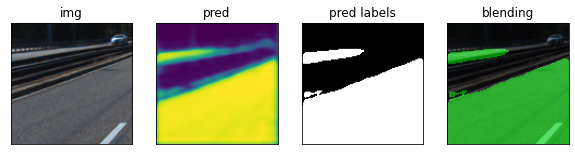

In [28]:
plt.figure(figsize=(10,4))
patch_index = 1
plt.subplot(1,4,1)
plt.title('img')
plt.imshow(patches[patch_index])
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,2)
plt.title('pred')
plt.imshow(predictions[patch_index,0])
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,3)
plt.title('pred labels')
plt.imshow(predictions[patch_index,0] > 0.5, 'gray')
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,4)
plt.title('blending')
plt.imshow(make_blending(patches[patch_index], predictions[patch_index,0] > 0.5))
plt.xticks([]); plt.yticks([])

If everything is fine, you should be able to predict output for input image of any shape. Try crop 256x256 (or smaller if it doesn't fit in memory)

(256, 848, 3)


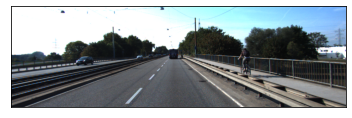

In [29]:
plt.imshow(im)
plt.xticks([]); plt.yticks([])
print(im.shape)

In [30]:
patch = im[:, 200:200+256]
predictions = apply_net(preproces(patch[np.newaxis]), net2)
predictions.shape, patch.shape

out1:  torch.Size([1, 32, 256, 256])
out2:  torch.Size([1, 64, 256, 256])
out3:  torch.Size([1, 128, 256, 256])
result:  torch.Size([1, 1, 256, 256])


((1, 1, 256, 256), (256, 256, 3))

([], [])

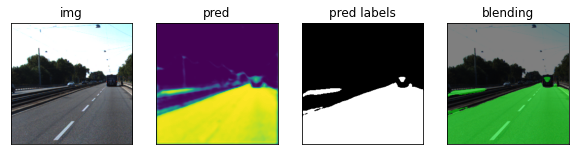

In [31]:
plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.title('img')
plt.imshow(patch)
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,2)
plt.title('pred')
plt.imshow(predictions[0,0])
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,3)
plt.title('pred labels')
plt.imshow(predictions[0,0] > 0.5, 'gray')
plt.xticks([]); plt.yticks([])
plt.subplot(1,4,4)
plt.title('blending')
plt.imshow(make_blending(patch, predictions[0,0] > 0.5))
plt.xticks([]); plt.yticks([])

In [32]:
def split_and_apply(net, image, patch_w=150, overlap=80):
    n_patches = image.shape[1] // patch_w
    labels = np.zeros(image.shape[:2], np.uint8)
    for i in range(n_patches):
        print(i,n_patches)
        patch = image[:, max(0, i*patch_w-overlap): min((i+1)*patch_w+overlap, image.shape[1])]
        extra_left = i*patch_w - max(0, i*patch_w-overlap)
        extra_right = min(image.shape[1], (i+1)*patch_w+overlap) - (i+1)*patch_w
        out = (apply_net(preproces(patch[np.newaxis]), net)[0,0] > 0.5).astype(np.uint8)
        labels[:, i*patch_w: (i+1)*patch_w] = out[:,extra_left:-extra_right]
    if n_patches*patch_w < image.shape[1]:
        last_patch_size = image.shape[1] - n_patches*patch_w
        patch = image[:,-patch_w:]
        labels[:,-last_patch_size:] = (apply_net(preproces(patch[np.newaxis]), net)[0,0] > 0.5).astype(np.uint8)[:,-last_patch_size:]
    return labels

In [33]:
#!M
labels = split_and_apply(net2, im)

0 5
out1:  torch.Size([1, 32, 256, 230])
out2:  torch.Size([1, 64, 256, 230])
out3:  torch.Size([1, 128, 256, 230])
result:  torch.Size([1, 1, 256, 230])
1 5
out1:  torch.Size([1, 32, 256, 310])
out2:  torch.Size([1, 64, 256, 310])
out3:  torch.Size([1, 128, 256, 310])
result:  torch.Size([1, 1, 256, 310])
2 5
out1:  torch.Size([1, 32, 256, 310])
out2:  torch.Size([1, 64, 256, 310])
out3:  torch.Size([1, 128, 256, 310])
result:  torch.Size([1, 1, 256, 310])
3 5
out1:  torch.Size([1, 32, 256, 310])
out2:  torch.Size([1, 64, 256, 310])
out3:  torch.Size([1, 128, 256, 310])
result:  torch.Size([1, 1, 256, 310])
4 5
out1:  torch.Size([1, 32, 256, 310])
out2:  torch.Size([1, 64, 256, 310])
out3:  torch.Size([1, 128, 256, 310])
result:  torch.Size([1, 1, 256, 310])
out1:  torch.Size([1, 32, 256, 150])
out2:  torch.Size([1, 64, 256, 150])
out3:  torch.Size([1, 128, 256, 150])
result:  torch.Size([1, 1, 256, 150])


([], [])

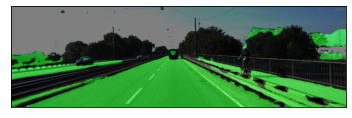

In [34]:
plt.imshow(make_blending(im, labels))
plt.xticks([]); plt.yticks([])

### TL;DR DeepLab v2 architecture:
![alt text](https://miro.medium.com/max/1283/1*8Lg66z7e7ijuLmSkOzhYvA.png "Somthing wrong with image")